# Emotion Detection Data Preparation

This notebook demonstrates the steps to prepare the GoEmotions dataset for a multi-label classification task.

 We will perform the following steps:
1. Group and sum emotion labels for each unique text.
2. Clean the dataset by removing conflicting neutral labels.
3. Retain only the top 3 emotion labels per text.
4. Stratify the dataset based on the labels.
5. Visualize the data before and after each step.


## Step 1: Load the Data
First, we load the GoEmotions dataset and inspect its structure.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset

dataFrame = load_dataset('go_emotions', 'raw')
print("Total data size: ", len(dataFrame["train"]))
df = dataFrame["train"].to_pandas()
df.to_parquet("go_emotions.parquet")
df.head(2)

c:\ProgramData\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total data size:  211225


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Inspecting the text column

* We want to look at the text column and determine the max_sequence_length our model will have to handle.
* And to avoid data-leakage between test and validation we also want to deduplicate the text column

In [2]:
import matplotlib
df["length_text"] = df["text"].apply(len)
df["length_text"].describe()


count    211225.000000
mean         69.299572
std          36.536746
min           2.000000
25%          39.000000
50%          67.000000
75%          97.000000
max         703.000000
Name: length_text, dtype: float64

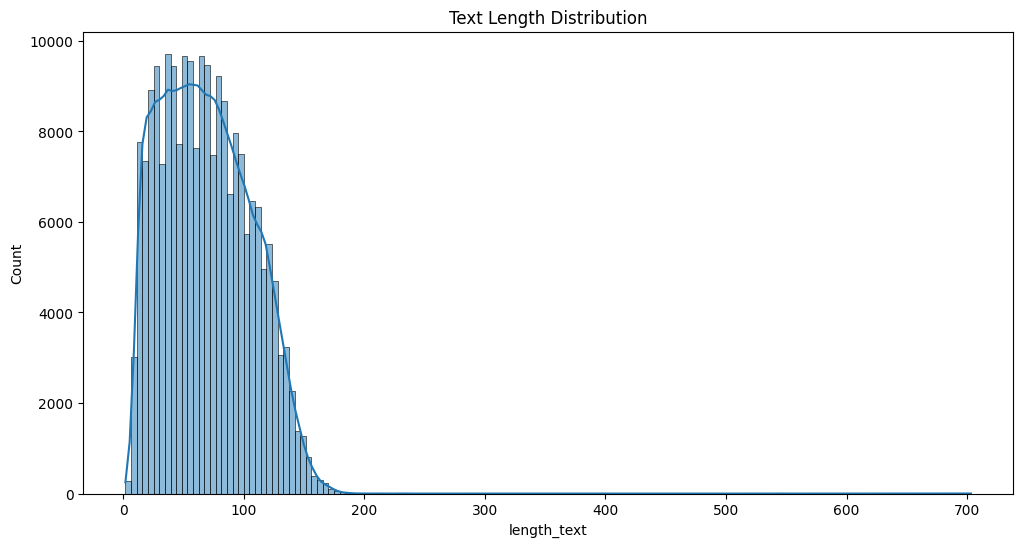

In [3]:

plt.figure(figsize=(12, 6))
sns.histplot(df["length_text"], bins=150, kde=True)
plt.title("Text Length Distribution")
plt.show()

In [7]:
# display the rows with text length lower than 10
df[df["length_text"] < 3]["text"].unique()[:100]

array(['ok', 'XD'], dtype=object)

In [8]:
# display the rows with text length larget than 200
df[df["length_text"] > 200]["text"].unique()

array(['No the whippet sound is WUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUB And then you need another balloon. Spot on with the gunshot though. Just like intense temporary tinnitus.',
       'It violates my right to enjoy my tinnitus. eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee',
       'here you go: |Games|Home|Away|Team|vs W-L 18-19| |:-|:-|:-|:-|-:| |1|1|0|Golden State|0-1| |2|1|1|Houston|0-0| |2|1|1|Oklahoma City|0-0| |2|0|2|Toronto|1-1| |2|1|1|Milwaukee|0-1| |3|1|2|Indiana|0-1| |2|1|1|Philadelphia|1-1| |2|1|1|Boston|1-0| |1|1|0|Minnesota|0-1| |2|1|1|New Orleans|0-0| |2|1|1|Memphis|0-0| |1|1|0|Dallas|0-1| |1|0|1|Mia

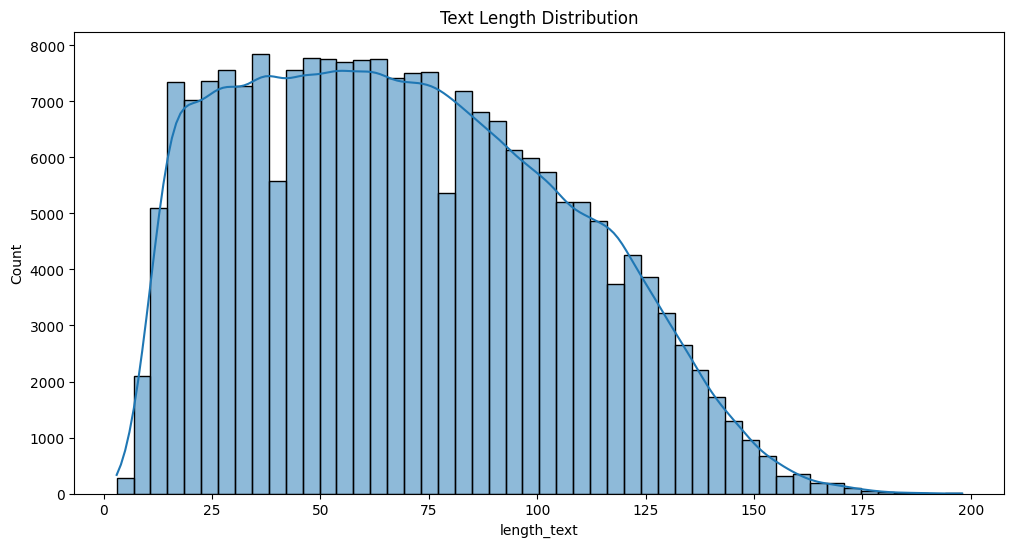

In [9]:

# suppress < 3 and > 256
df = df[(df["length_text"] >= 3) & (df["length_text"] <= 200)]
# plot
plt.figure(figsize=(12, 6))
sns.histplot(df["length_text"], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.show()


## Step 2: Group and Sum Emotion Labels
Next, we group the dataset by text and sum the emotion labels for each unique text.

In [10]:
df["text"].describe()

count         211200
unique         57724
top       Thank you.
freq              45
Name: text, dtype: object

In [13]:
# Columns containing emotion labels
emotions = df.columns[9:-1]

# Group by text and sum the emotion columns
df_grouped = df.groupby('text', as_index=False)[emotions].sum()

# Display the first few rows of the grouped dataset
print("Grouped Dataset:")
print(df_grouped.head())
df_grouped

Grouped Dataset:
                                                text  admiration  amusement  \
0   "If you don't wear BROWN AND ORANGE...YOU DON...           0          0   
1   "What do Scottish people look like?" How I wo...           0          0   
2     ### A surprise, to be sure, but a welcome one            0          0   
3   '*Pray*, v. To ask that the laws of the unive...           0          0   
4   >it'll get invaded by tankie, unfortunately. ...           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      1          2         1       0          0          0       0  ...   
1      0          0         0       0          0          3       0  ...   
2      0          0         0       0          0          0       0  ...   
3      0          0         0       0          0          0       0  ...   
4      0          0         0       0          0          0       0  ...   

   love  nervousness  optimism  pride  realization 

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,1,2,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,3,0,...,2,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57719,🤷🏻‍♀️ As a wise man once said: he was a bastar...,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
57720,🤷🏼‍♀️ I was wondering the same thing. It looke...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,2,0
57721,🦀MY BABYS DEAD🦀,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
57722,🦀🦀🦀🦀🦀🦀🦀🦀🦀I’m bad at this game🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


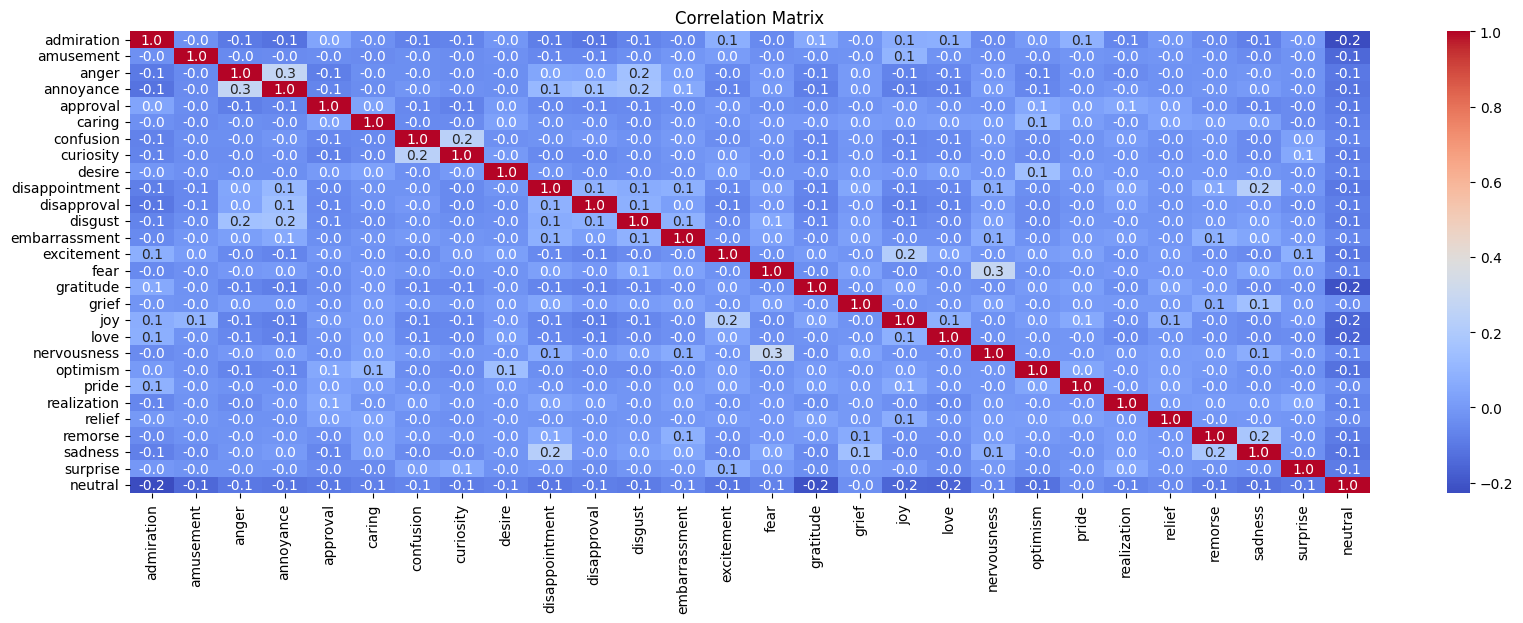

In [14]:
# plot a confusion matrix displaying the counts of each emotion
plt.figure(figsize=(20, 6))
sns.heatmap(df_grouped[emotions].corr(), annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

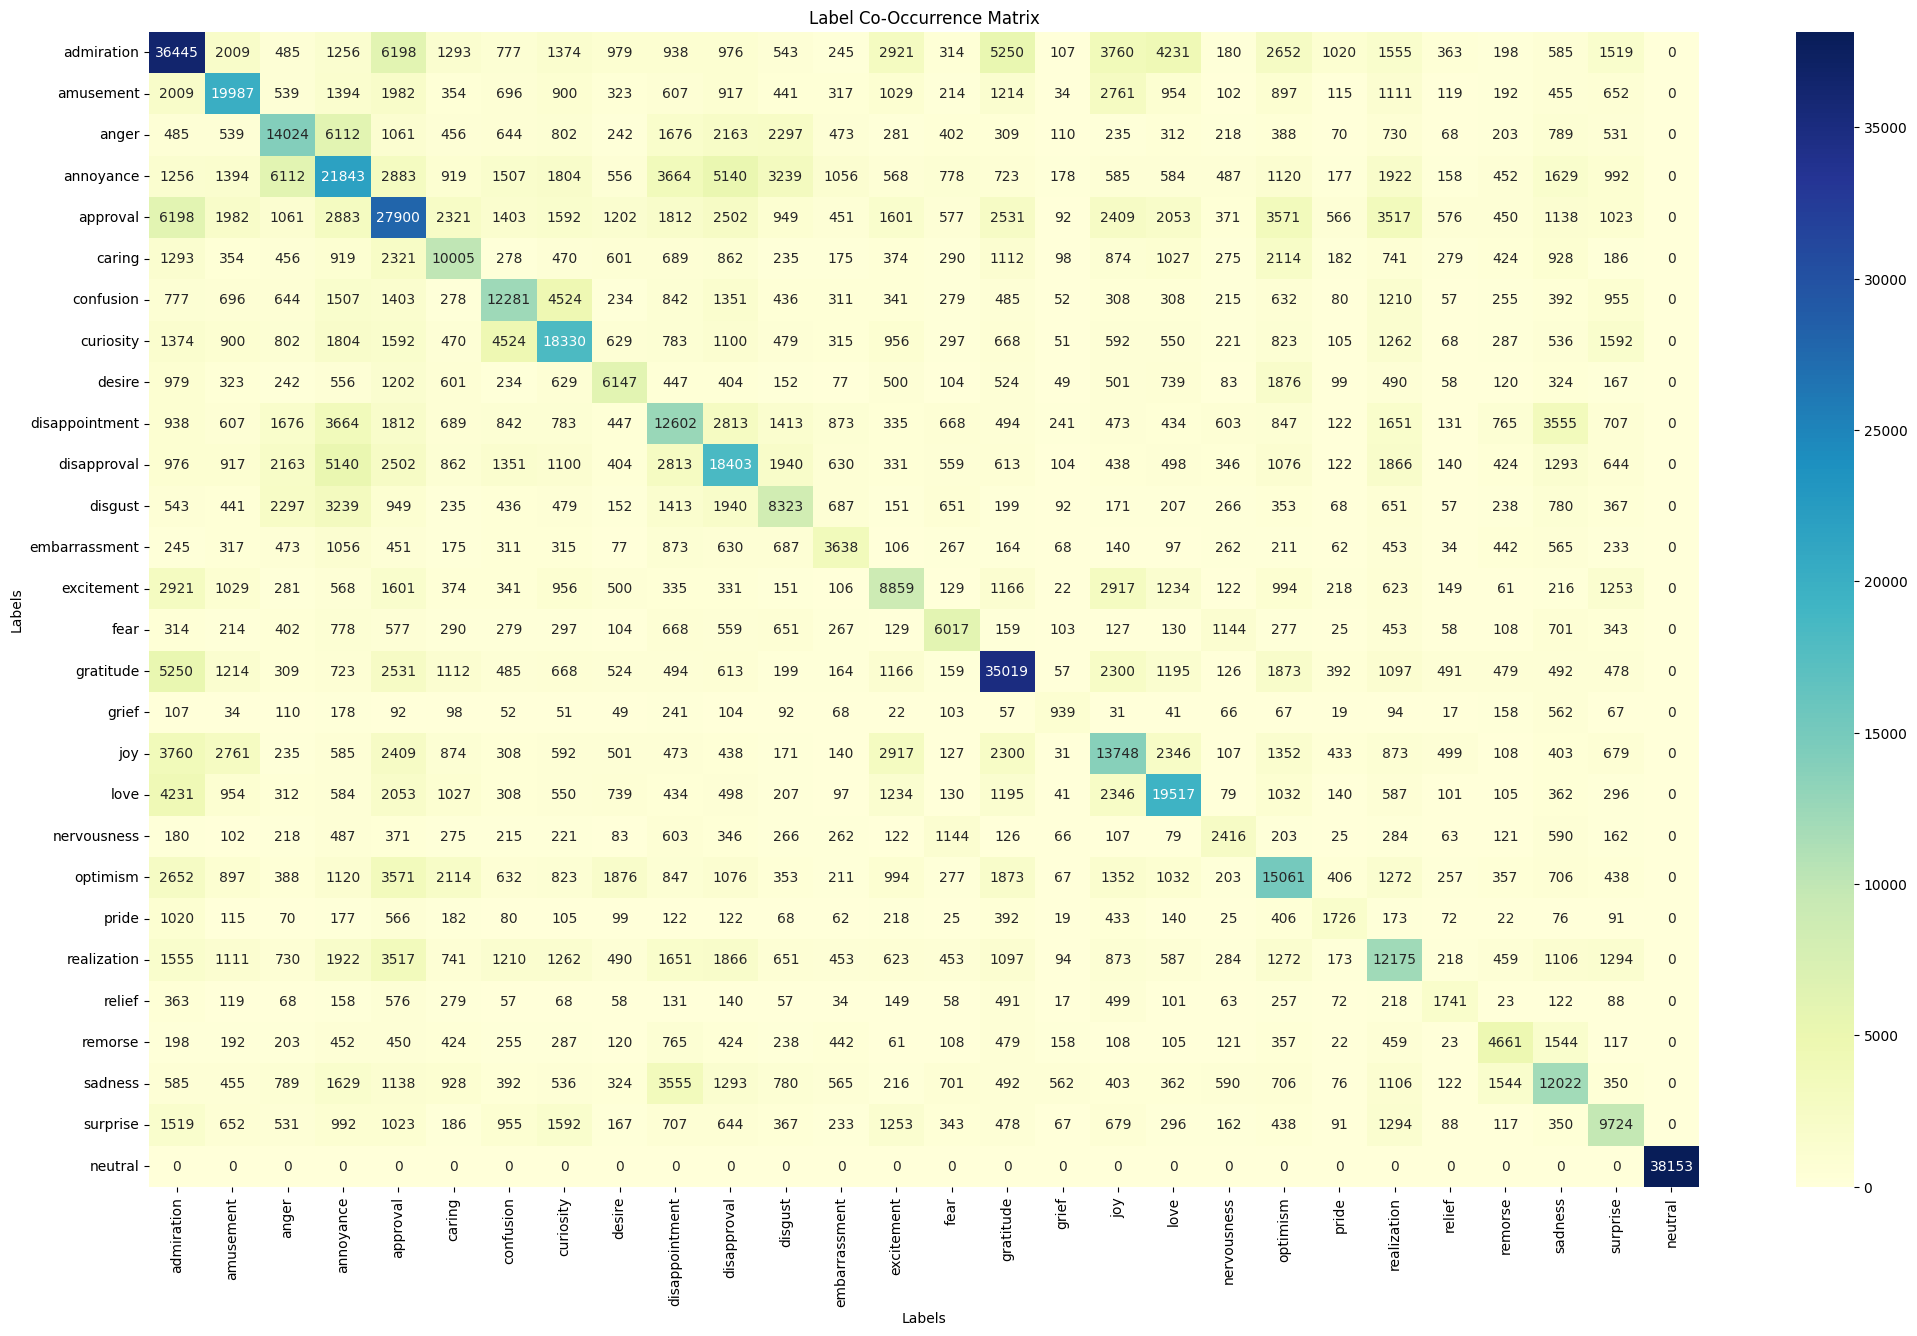

In [19]:

# Create a DataFrame from the labels
labels_df = df_grouped[emotions]

# Calculate the co-occurrence matrix
co_occurrence_matrix = labels_df.T.dot(labels_df)

# Convert to a DataFrame for better readability
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, columns=labels_df.columns, index=labels_df.columns)

# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(co_occurrence_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Label Co-Occurrence Matrix')
plt.xlabel('Labels')
plt.ylabel('Labels')
plt.show()

## Step 3: Remove Conflicting Neutral Labels
We remove the neutral label if it is set amongst other labels.

In [16]:
all_except_neutral = emotions[:-1]
all_except_neutral

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise'],
      dtype='object')

In [17]:
# count the number of times neutral is present along with other emotions
df_grouped["neutral_only"] = df_grouped[all_except_neutral].sum(axis=1) == 0
df_grouped["neutral_and_other"] = df_grouped["neutral_only"] == False
print("Neutral Only:", df_grouped["neutral_only"].sum())
print("Neutral and Other:", df_grouped["neutral_and_other"].sum())
# number of items with neutral above 1 
df_grouped["neutral_above_1"] = df_grouped["neutral"] > 1
print("Neutral above 1:", df_grouped["neutral_above_1"].sum())

Neutral Only: 4237
Neutral and Other: 53487
Neutral above 1: 17736


In [18]:
# Clean up the dataset by removing the neutral label if it conflicts with other labels
def remove_conflicting_neutral(row):
    if row['neutral'] > 0 and row[all_except_neutral].sum() > 0:
        row['neutral'] = 0
    return row

df_grouped = df_grouped.apply(remove_conflicting_neutral, axis=1)

# Display the first few rows after removing conflicting neutral labels
print("Dataset after Removing Conflicting Neutral Labels:")
# count the number of times neutral is present along with other emotions
df_grouped["neutral_only"] = df_grouped[all_except_neutral].sum(axis=1) == 0
df_grouped["neutral_and_other"] = df_grouped["neutral_only"] == False
print("Neutral Only:", df_grouped["neutral_only"].sum())
print("Neutral and Other:", df_grouped["neutral_and_other"].sum())
# number of items with neutral above 1 
df_grouped["neutral_above_1"] = df_grouped["neutral"] > 1
print("Neutral above 1:", df_grouped["neutral_above_1"].sum())

Dataset after Removing Conflicting Neutral Labels:
Neutral Only: 4237
Neutral and Other: 53487
Neutral above 1: 4190


## Step 4: Retain Only Top 3 Labels
For each row, we keep only the top 3 emotion labels with the highest scores and set those to 1, while setting all other labels to 0.


In [20]:
import numpy as np

# Function to keep only the top 3 labels
def keep_top_labels(row, top_labels=3):
    top_indices = row.nlargest(top_labels).index
    # only keep those labels where the value is greater than 0
    top_indices = top_indices[row[top_indices] > 0]
    row[:] = 0
    row[top_indices] = 1
    return row

# Apply the function to each row
df_grouped[emotions] = df_grouped[emotions].apply(lambda l: keep_top_labels(l, 3), axis=1)

# Display the first few rows after keeping only the top 3 labels
print("Dataset after Keeping Only Top Labels:")
print(df_grouped.head())

Dataset after Keeping Only Top Labels:
                                                text  admiration  amusement  \
0   "If you don't wear BROWN AND ORANGE...YOU DON...           0          0   
1   "What do Scottish people look like?" How I wo...           0          0   
2     ### A surprise, to be sure, but a welcome one            0          0   
3   '*Pray*, v. To ask that the laws of the unive...           0          0   
4   >it'll get invaded by tankie, unfortunately. ...           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      1          1         1       0          0          0       0  ...   
1      0          0         0       0          0          1       0  ...   
2      0          0         0       0          0          0       0  ...   
3      0          0         0       0          0          0       0  ...   
4      0          0         0       0          0          0       0  ...   

   pride  realization  relief

## Step 5: Stratify the Dataset
We stratify the dataset based on the labels to ensure the distribution of labels is maintained.

In [24]:
from sklearn.model_selection import train_test_split

# shuffle the dataset
df_grouped = df_grouped.sample(frac=1, random_state=42)

# Create a multi-label indicator for stratification
df_grouped['labels'] = df_grouped[emotions].apply(lambda x: tuple(x), axis=1)


In [25]:
# Count the occurrences of each label combination
label_counts = df_grouped['labels'].value_counts()
label_counts

labels
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    4235
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    2057
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    1405
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    1225
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    1073
                                                                                        ... 
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0)       1
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0)       1
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0)       1
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)       1
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

In [29]:
28*27*26

19656

In [26]:
# count of label combinations occuring only once
single_label_counts = label_counts[label_counts == 1].count()
print(f"Label combinations occuring only once: {single_label_counts}")

Label combinations occuring only once: 485


In [27]:

# Identify rare combinations (those that appear less than twice)
rare_combinations = label_counts[label_counts < 2].index
print("Rare Combinations:", len(rare_combinations))

# Filter out rows with rare combinations
df_filtered = df_grouped[~df_grouped['labels'].isin(rare_combinations)]

# Stratify the dataset
train, test = train_test_split(df_filtered, test_size=0.1, random_state=42, shuffle=True,  stratify=df_filtered['labels'])

# Drop the 'labels' column as it was only needed for stratification
train = train.drop(columns=['labels'])
test = test.drop(columns=['labels'])

# Display the resulting datasets
print("Training set size:", len(train))
print("Test set size:", len(test))


Rare Combinations: 485
Training set size: 51515
Test set size: 5724


## Visualizations
Let's visualize the distribution of labels before and after each step.

### Original Dataset


C:\Users\sebdg\AppData\Local\Temp\ipykernel_9888\2971567193.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_emotion_counts.index, y=original_emotion_counts.values, palette="viridis")


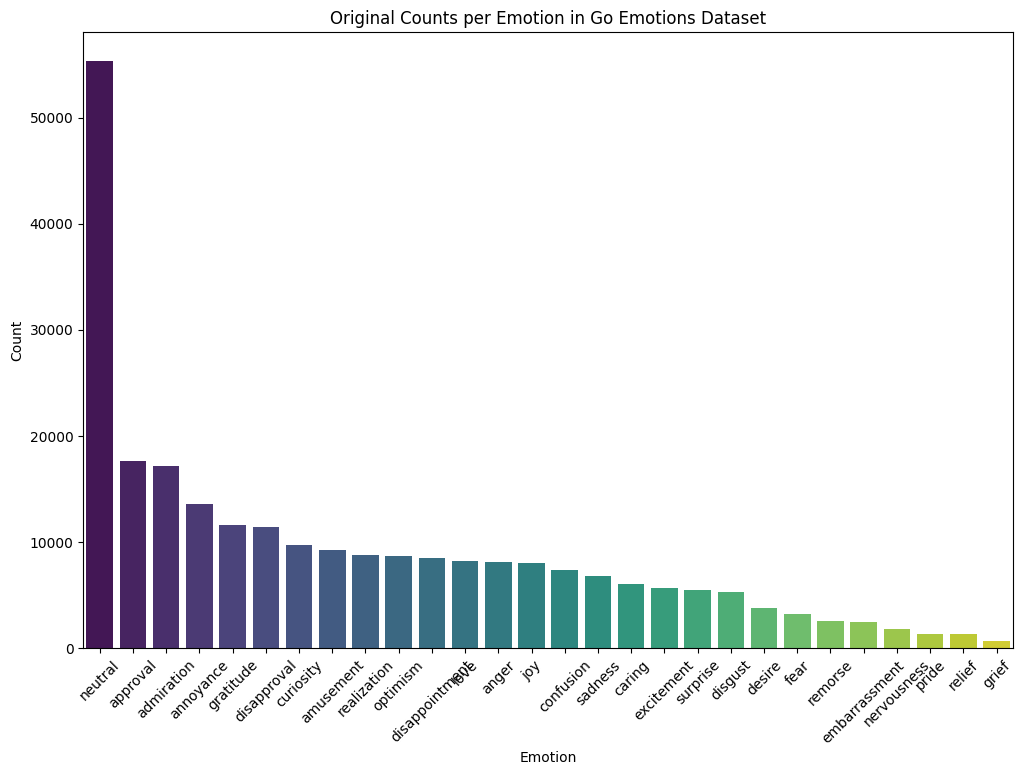

In [28]:
# Plot the original distribution of emotion labels
import matplotlib.pyplot as plt
import seaborn as sns

original_emotion_counts = df[emotions].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=original_emotion_counts.index, y=original_emotion_counts.values, palette="viridis")
plt.title('Original Counts per Emotion in Go Emotions Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Cleaned Dataset

<Axes: >

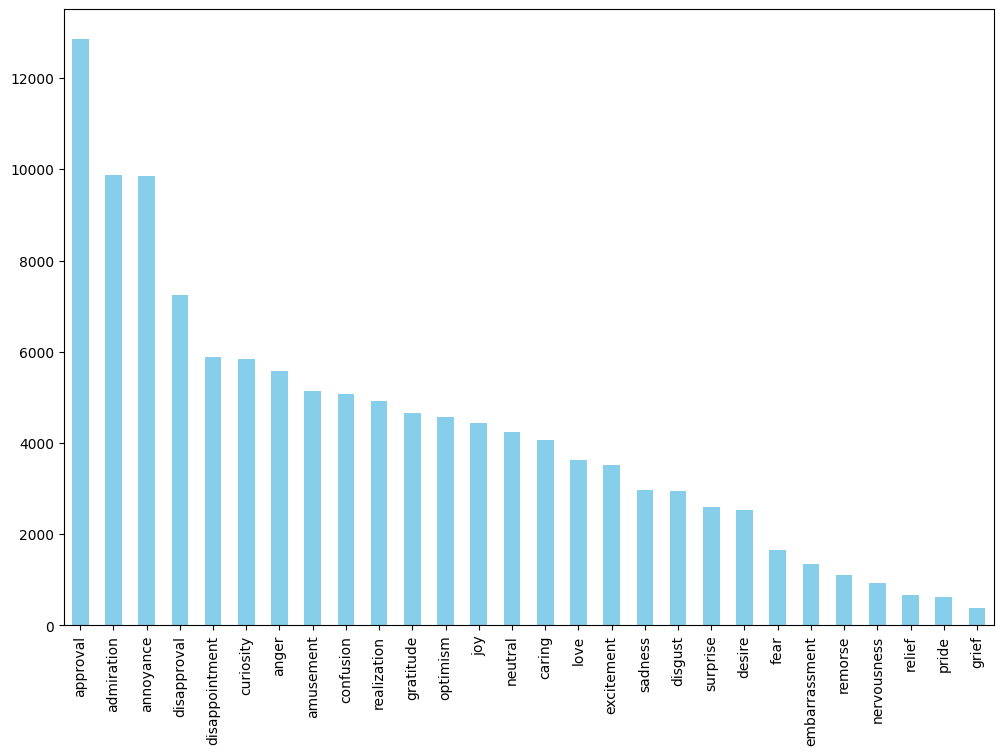

In [29]:
# Plot the distribution of emotion labels after removing conflicting neutral labels
cleaned_emotion_counts = df_grouped[emotions].sum().sort_values(ascending=False)

# plot histogram
plt.figure(figsize=(12, 8))
cleaned_emotion_counts.plot(kind='bar', color='skyblue')


### Dataset with Top 3 Labels


### Test Set


In [30]:
# Calculate emotion counts for the training set
train_emotion_counts = train[emotions].sum()

# Calculate emotion counts for the test set
test_emotion_counts = test[emotions].sum()

# Combine the counts into a DataFrame
emotion_counts_df = pd.DataFrame({
    'Train': train_emotion_counts,
    'Test': test_emotion_counts
})

# Display the combined DataFrame
print("Emotion Counts in Train and Test Sets:")
print(emotion_counts_df)


Emotion Counts in Train and Test Sets:
                Train  Test
admiration       8843   983
amusement        4586   505
anger            4978   544
annoyance        8832   996
approval        11546  1293
caring           3618   405
confusion        4510   505
curiosity        5210   583
desire           2257   240
disappointment   5266   596
disapproval      6473   724
disgust          2615   282
embarrassment    1171   123
excitement       3108   349
fear             1430   157
gratitude        4143   465
grief             286    21
joy              3950   434
love             3209   346
nervousness       783    77
optimism         4081   454
pride             516    50
realization      4379   493
relief            537    56
remorse           934    93
sadness          2638   291
surprise         2275   253
neutral          3811   424


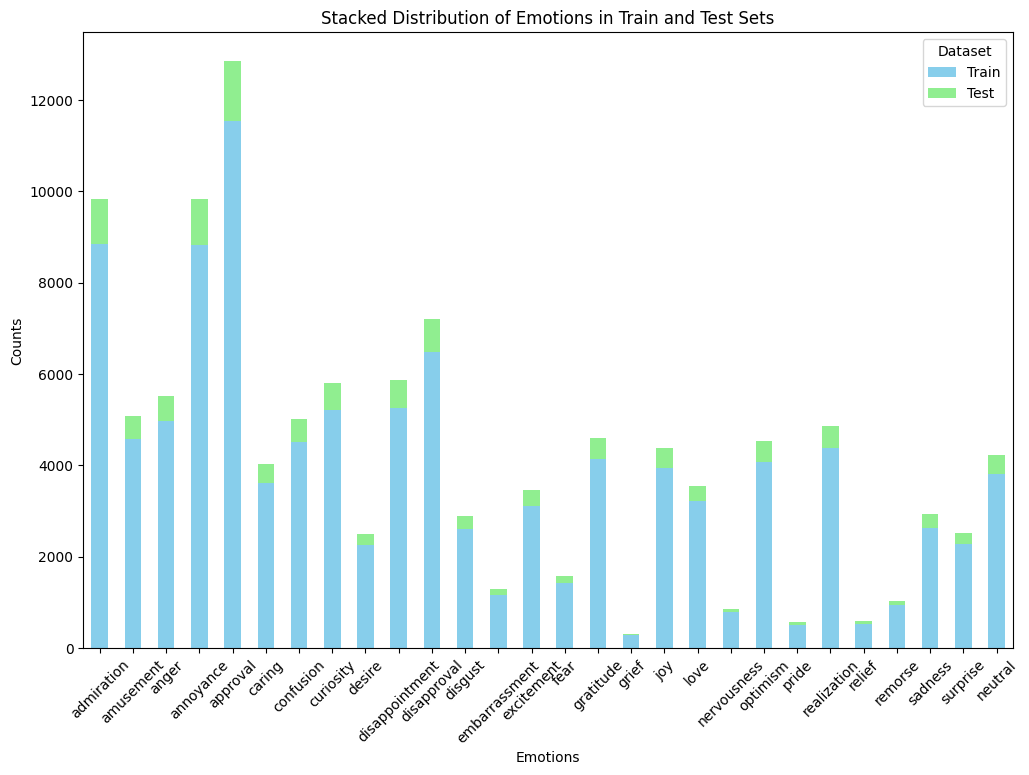

In [31]:
import matplotlib.pyplot as plt

# Plot the stacked bar chart
emotion_counts_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=['skyblue', 'lightgreen'])

# Add titles and labels
plt.title('Stacked Distribution of Emotions in Train and Test Sets')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.show()


## Step 6: Stacked Distribution of Emotions in Train and Test Sets
Finally, let's visualize the distribution of emotions in the training and test sets using a stacked bar chart.

In [32]:
# Calculate emotion counts for the training set
train_emotion_counts = train[emotions].sum()

# Calculate emotion counts for the test set
test_emotion_counts = test[emotions].sum()

# Combine the counts into a DataFrame
emotion_counts_df = pd.DataFrame({
    'Train': train_emotion_counts,
    'Test': test_emotion_counts
})

# Calculate total counts for sorting
emotion_counts_df['Total'] = emotion_counts_df['Train'] + emotion_counts_df['Test']

# Sort the DataFrame by total counts
emotion_counts_df = emotion_counts_df.sort_values(by='Total', ascending=False)

# Drop the total column for plotting
emotion_counts_df = emotion_counts_df.drop(columns=['Total'])

# Display the sorted combined DataFrame
print("Sorted Emotion Counts in Train and Test Sets:")
print(emotion_counts_df)



Sorted Emotion Counts in Train and Test Sets:
                Train  Test
approval        11546  1293
annoyance        8832   996
admiration       8843   983
disapproval      6473   724
disappointment   5266   596
curiosity        5210   583
anger            4978   544
amusement        4586   505
confusion        4510   505
realization      4379   493
gratitude        4143   465
optimism         4081   454
joy              3950   434
neutral          3811   424
caring           3618   405
love             3209   346
excitement       3108   349
sadness          2638   291
disgust          2615   282
surprise         2275   253
desire           2257   240
fear             1430   157
embarrassment    1171   123
remorse           934    93
nervousness       783    77
relief            537    56
pride             516    50
grief             286    21


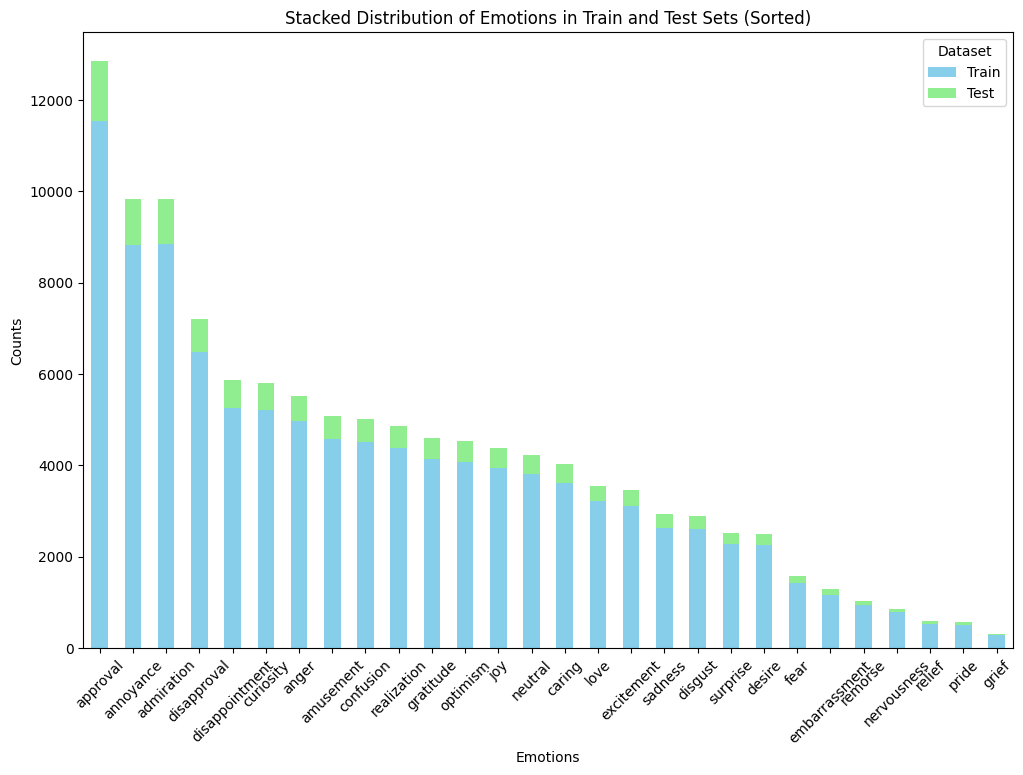

In [33]:
import matplotlib.pyplot as plt

# Plot the stacked bar chart
emotion_counts_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=['skyblue', 'lightgreen'])

# Add titles and labels
plt.title('Stacked Distribution of Emotions in Train and Test Sets (Sorted)')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.show()


## Save the datasets to Parquet file

In [34]:
train.to_parquet("go_emotions_train.parquet")
test.to_parquet("go_emotions_test.parquet")